# Galaxy Classification with QIMP (FRQI) on IBM Q 

## Group: JediMasters

#### FRQI: 

The algorithm transforms a state with all qubits in the |0⟩ state to the FRQI state, which stores an RGB image. Once the image has been stored and the state is measured a number of times to attempt to recover the RGB values in the image. 
There are three main phases for the algorithm: 

1.	The first phase involves converting an array of RGB triplets, which represent an image, into angles in [0, π/2]. 

2.	The  angles are then sent to a function which uses two operations to store them in a quantum state, keeping track of which angle represents a color in which pixel of the image. The algorithm starts with 2n + 1 qubits in the |0⟩ state. The first operation applies Hadamard gates to 2n of the qubits. The second operation is a succession of rotations about the Y axis by 2θi controlled by 2n qubits. CNOT and controlled y-rotation gates are applied to accomplish rotating by 2θ only the basis vectors corresponding to the pixels whose colour is being encoded in the state. Once all the colours have been encoded, the state is finalised.

3.	Recovery of the image: this is done by repeatedly measuring the state to get estimates for the probability of measure |0⟩ for each pixel and using that to recover θi. The θ values are then converted back to RGB values and the image is recovered.



In [73]:
from qiskit import IBMQ, QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, QuantumRegister
from qiskit.qasm import pi
from qiskit.tools.visualization import plot_histogram, circuit_drawer
from qiskit import execute, Aer, BasicAer
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

In [12]:

import quantum_edge_detection as qed

from qiskit import IBMQ
IBMQ.save_account('5410725d63b096bb909fb3208b6367a7b2e7f094acfe6fce597e4d84f1149a4f6f8a7f38532dc5335a5074a5dbaef3def1c0a995f0b11f1de411266ead2cf551')

#IBMQ.load_account('5410725d63b096bb909fb3208b6367a7b2e7f094acfe6fce597e4d84f1149a4f6f8a7f38532dc5335a5074a5dbaef3def1c0a995f0b11f1de411266ead2cf551')


configrc.store_credentials:WARNING:2020-07-22 12:01:57,632: Credentials already present. Set overwrite=True to overwrite.


In [13]:
anc = QuantumRegister(1, "anc")
img = QuantumRegister(11, "img")
anc2 = QuantumRegister(1, "anc2")
c = ClassicalRegister(12)

qc = QuantumCircuit(anc, img, anc2, c)

In [18]:
from keras import utils
import numpy as np
from sklearn.model_selection import train_test_split
import pylab as plt


from astroNN.datasets import galaxy10
from astroNN.datasets.galaxy10 import galaxy10cls_lookup, galaxy10_confusion

WARNING! APOGEE environment variable SDSS_LOCAL_SAS_MIRROR not set
WARNING! Gaia environment variable GAIA_TOOLS_DATA not set


In [19]:
# Load images and labels (will download automatically at the first time)
# First time downloading location will be ~/.astroNN/datasets/
images, labels = galaxy10.load_data()

Galaxy10.h5: 100%|█████████▉| 210M/210M [04:36<00:00, 784kB/s]    

Downloaded Galaxy10 successfully to /home/sgangoly/.astroNN/datasets/Galaxy10.h5


Galaxy10.h5: 210MB [04:36, 759kB/s]                           


===================Data Inspection===================


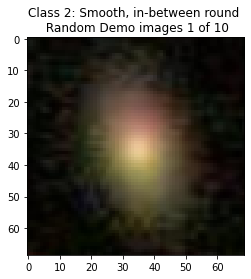

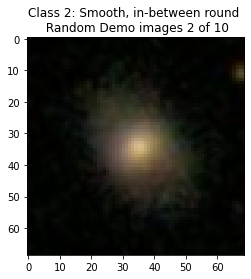

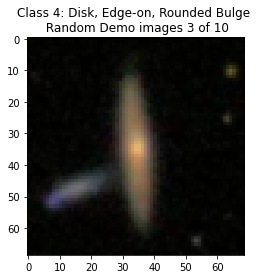

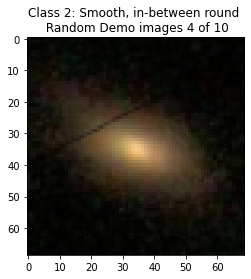

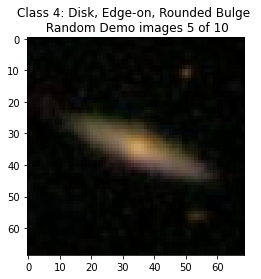

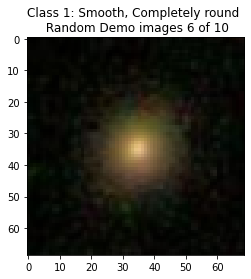

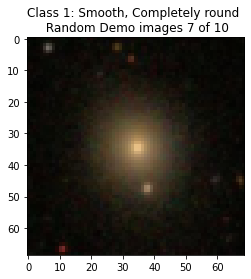

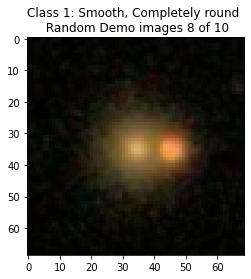

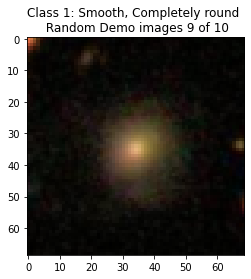

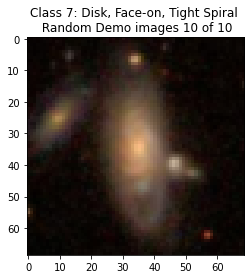

===============Data Inspection Finished===============


In [20]:
# To convert the labels to categorical 10 classes
labels = utils.to_categorical(labels, 10)

# Select 10 of the images to inspect
img = None
plt.ion()
print('===================Data Inspection===================')
for counter, i in enumerate(range(np.random.randint(0, labels.shape[0], size=10).shape[0])):
    img = plt.imshow(images[i])
    plt.title('Class {}: {} \n Random Demo images {} of 10'.format(np.argmax(labels[i]), galaxy10cls_lookup(labels[i]), counter+1))
    plt.draw()
    plt.pause(2.)
plt.close('all')
print('===============Data Inspection Finished===============')


In [22]:
imageNames = ["refdisk.jpg", "ecross.jpg", "disk4.jpg"]
imageNum1 = 0
imageNum2 = 2

image1 = Image.open(imageNames[imageNum1]).convert('LA')
image2 = Image.open(imageNames[imageNum2]).convert('LA')

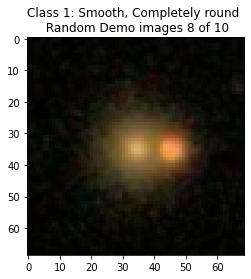

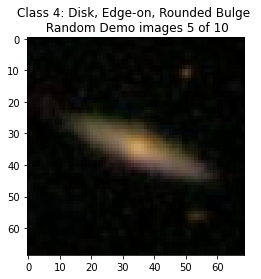

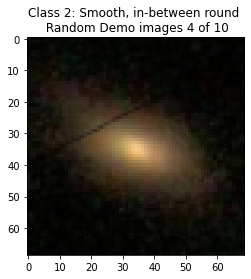

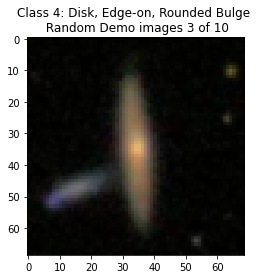

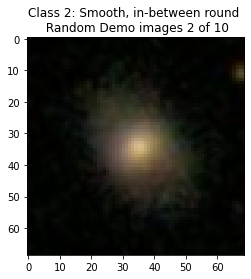

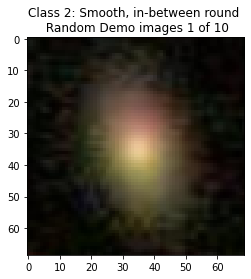

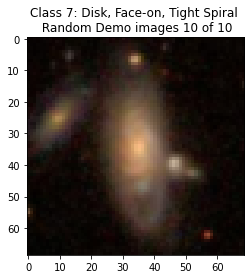

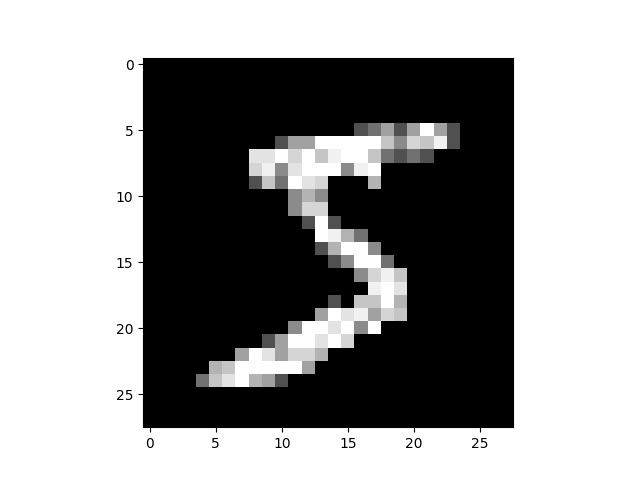

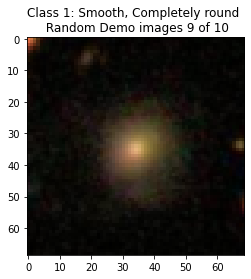

In [60]:
fs = !ls *.png

import IPython.display as dp

# create list of image objects
images = []
for ea in fs:
    images.append(dp.Image(filename=ea, format='png'))

# display all images
for ea in images:
    dp.display_png(ea)

In [61]:


from resizeimage import resizeimage
def image_normalization(image):
    image = resizeimage.resize_cover(image, [32, 32])
    w, h = 32, 32
    image = np.array([[image.getpixel((x,y))[0] for x in range(w)] for y in range(h)])

    # 2-dimentional data convert to 1-dimentional array
    image = image.flatten()
    # change type
    image = image.astype('float64')
    # Normalization(0~pi/2)
    image /= 255.0
    generated_image = np.arcsin(image)

    return generated_image

In [26]:
image1 = image_normalization(image1)
image2 = image_normalization(image2)

In [36]:
import sys
import utils
import frqi_qkt

In [ ]:
def main():

	# use 10 shots
	if (len(sys.argv) == 1):
		num_shots = 10
	else:
		num_shots = int(sys.argv[1])

	image = utils.get_image()
	size = len(image)

	angles = []
	# convert rgb pixel values into angles in [0, pi/2]
	for i in range(size):
		for j in range(size):
			angles.append((utils.rgb_to_theta(image[i][j])))

	new_angles = frqi_qkt.run(angles, num_shots)

	im = []
	i = 0
	# convert recovered angles into rgb values
	for ang in new_angles:

		rgb = utils.theta_to_rgb(ang)
		if (i % 2 == 0):
			row = []

		row.append(rgb)

		if (i % 2 != 0):
			im.append(row)

		i += 1

	# image using the recovered RGB values
	new_image = utils.make_image(im)

if __name__ == "__main__":
    main()

In [41]:
# Ref: https://qiskit.org/textbook/ch-machine-learning/machine-learning-qiskit-pytorch.html

import torch
from torch.autograd import Function
#from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit.visualization import *

### Create a "Quantum Class" with Qiskit 
Hard code the circuit for simplicity and use a  RY− rotation by the angle  θ  to train the output of our circuit. 
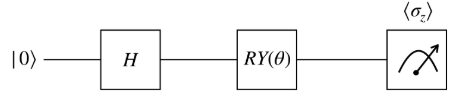

measure the output in the  z− basis -->  calculate the  $σ_{z}$  expectation.

In [42]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        job = qiskit.execute(self._circuit, 
                             self.backend, 
                             shots = self.shots,
                             parameter_binds = [{self.theta: theta} for theta in thetas])
        result = job.result().get_counts(self._circuit)
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])


In [43]:
simulator = qiskit.Aer.get_backend('qasm_simulator')

circuit = QuantumCircuit(1, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw()

Expected value for rotation pi 0.58


┌───┐ ░ ┌───────────┐ ░ ┌─┐
   q_0: ┤ H ├─░─┤ RY(theta) ├─░─┤M├
        └───┘ ░ └───────────┘ ░ └╥┘
meas_0: ═════════════════════════╩═

### Create a "Quantum-Classical Class" with PyTorch

In [44]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)


In [ ]:
#Train the data
from torchvision import datasets, transforms
images = 8

X_train = datasets.galaxy10(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:images], 
                np.where(X_train.targets == 1)[0][:images])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

In [69]:
images = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=img, figsize=(10, 3))

while img > 0:
    images, targets = data_iter.__next__()

    axes[images - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[images - 1].set_xticks([])
    axes[images - 1].set_yticks([])
    axes[images - 1].set_title("Labeled: {}".format(targets.item()))
    
    images -= 1


NameError: name 'train_loader' is not defined